In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),#we convert it into tensor
    transforms.Normalize((0.1307,),(0.3081,)) # Normalizes with mean and std
])

train_dataset=datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset=datasets.MNIST(root="./data",train=False , download=True, transform=transform)

train_loader=DataLoader(train_dataset,batch_size=64, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.36MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]


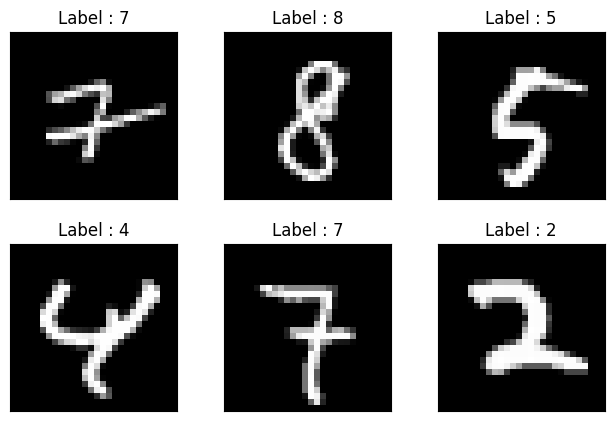

In [4]:
examples=enumerate(train_loader)
batch_idx,(example_data, example_targets)=next(examples)

fig=plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0],cmap="gray",interpolation='none')
  plt.title("Label : {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [5]:
# Redefine CNN class with corrections
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__() #here nn.Module is the base class super first call the constructor of parent class then furture work decide
    self.conv1=nn.Conv2d(1,32,kernel_size=3)
    self.conv2=nn.Conv2d(32,64,kernel_size=3)
    self.dropout1=nn.Dropout2d(0.25)
    self.dropout2=nn.Dropout(0.5)
    self.fc1=nn.Linear(9216,128)
    self.fc2=nn.Linear(128,10)

  def forward(self,x):
    x=F.relu(self.conv1(x))   #[batch,32,26,26] # Corrected: removed [x]
    x=F.relu(self.conv2(x))   #[batch,64,24,24] # Corrected: removed [x]
    x=F.max_pool2d(x,2)         #[batch,64,12,12]
    x=self.dropout1(x)
    x=torch.flatten(x,1)        #flatten all but batch
    x=F.relu(self.fc1(x))
    x=self.dropout2(x)          # Corrected: used self.dropout2
    x=self.fc2(x)               # Removed F.relu here, usually log_softmax follows directly
    return F.log_softmax(x,dim=1)

In [6]:
!pip install torchsummary

In [7]:
from torchsummary import summary
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=CNN().to(device)
optimizer=optim.Adam(model.parameters(), lr=0.001) # Corrected: model.parameters() is a method
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------


In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} "
                f"[{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):.0f}%)] "
                f"Loss: {loss.item():.6f}"
            )


In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} Accuracy: ({accuracy:.2f}%)")



In [10]:
for epoch in range(1,6):
  train(model,device,train_loader,optimizer,epoch)
  test(model,device,test_loader)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.308417
Train Epoch: 1 [6400/60000 (11%)] Loss: 0.176312
Train Epoch: 1 [12800/60000 (21%)] Loss: 0.246679
Train Epoch: 1 [19200/60000 (32%)] Loss: 0.184064
Train Epoch: 1 [25600/60000 (43%)] Loss: 0.155896
Train Epoch: 1 [32000/60000 (53%)] Loss: 0.236798
Train Epoch: 1 [38400/60000 (64%)] Loss: 0.049086
Train Epoch: 1 [44800/60000 (75%)] Loss: 0.060332
Train Epoch: 1 [51200/60000 (85%)] Loss: 0.264738
Train Epoch: 1 [57600/60000 (96%)] Loss: 0.086888

Test set: Average loss: 0.0536, Accuracy: 9813/10000 (98.13%)
Train Epoch: 2 [0/60000 (0%)] Loss: 0.178846
Train Epoch: 2 [6400/60000 (11%)] Loss: 0.077568
Train Epoch: 2 [12800/60000 (21%)] Loss: 0.114725
Train Epoch: 2 [19200/60000 (32%)] Loss: 0.047507
Train Epoch: 2 [25600/60000 (43%)] Loss: 0.114974
Train Epoch: 2 [32000/60000 (53%)] Loss: 0.049186
Train Epoch: 2 [38400/60000 (64%)] Loss: 0.060346
Train Epoch: 2 [44800/60000 (75%)] Loss: 0.087027
Train Epoch: 2 [51200/60000 (85%)] Loss: 0.006309

In [11]:
model_path="minist_cnn.pth"
torch.save(model.state_dict(),model_path)
print(f"model save to to {model_path}")

model save to to minist_cnn.pth


In [12]:
loaded_model=CNN().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("Model loaded successfully")

Model loaded successfully


In [20]:
def predict(model, device, data_loader, nums_sample=6):
  model.eval()
  data_iter=iter(data_loader)
  images, labels= next(data_iter)
  images, labels=images.to(device), labels.to(device)
  output=model(images)
  preds=output.argmax(dim=1) # Corrected: argmax should be called on the output, not the model

  fig=plt.figure()
  for i in range(nums_sample):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(images[i][0].cpu(), cmap="gray", interpolation='none')
    plt.title(f"Pred : {preds[i].item()}  Label : {labels[i].item()}")
    plt.xticks([])
    plt.yticks([])
  plt.show()

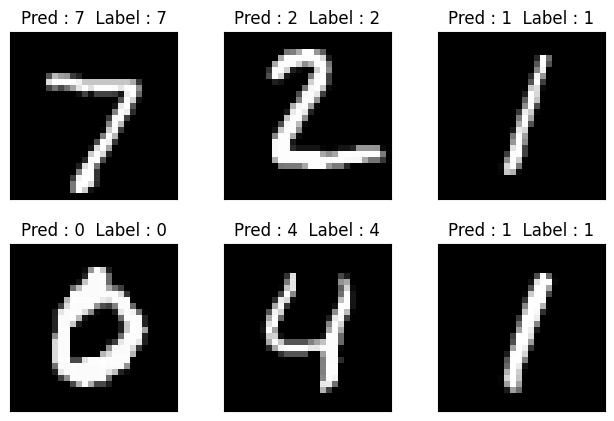

In [21]:
predict(loaded_model,device, test_loader)